In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

df_train = pd.read_csv('train_final.csv')
df_test = pd.read_csv('test_final.csv')

In [2]:
target = df_train["Y"]
id = df_test["Id"].values

df_train.drop(['Id','Y'],axis=1,inplace=True)
df_test.drop(['Id'],axis=1,inplace=True)

In [3]:
print('Binary features summary statistics')
df_train.describe().T.style.bar(subset = ['mean'], color = 'grey').bar(subset = ['std'],color = 'grey').background_gradient(cmap = 'GnBu')

Binary features summary statistics


,count,mean,std,min,25%,50%,75%,max
2,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
3,2603.000000,0.463312,0.498748,0.000000,0.000000,0.000000,1.000000,1.000000
4,2603.000000,-46.734537,394.284920,-3136.000000,0.000000,0.000000,0.000000,1175.000000
5,2603.000000,0.000768,0.027714,0.000000,0.000000,0.000000,0.000000,1.000000
6,2603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,2603.000000,0.275836,0.447020,0.000000,0.000000,0.000000,1.000000,1.000000
8,2603.000000,0.023434,0.151308,0.000000,0.000000,0.000000,0.000000,1.000000
9,2603.000000,0.000384,0.019600,0.000000,0.000000,0.000000,0.000000,1.000000
10,2603.000000,0.955436,0.206384,0.000000,1.000000,1.000000,1.000000,1.000000
11,2603.000000,0.001921,0.043794,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
from sklearn import preprocessing

#columns = ['4','63','132', '146', '180','382', '119', '198', '379']
columns = ['4','63','132',  '180','382',  '379']
minmax_scale_train = preprocessing.MinMaxScaler().fit(df_train[columns])
df_train[columns] = minmax_scale_train.transform(df_train[columns])

minmax_scale_test = preprocessing.MinMaxScaler().fit(df_test[columns])
df_test[columns] = minmax_scale_test.transform(df_test[columns])

In [5]:
drop_extras = ['146','198']

df_train =  df_train.drop(drop_extras,axis=1)        
df_test = df_test.drop(drop_extras,axis=1)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_train, target, test_size=0.33, random_state=1)

In [7]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


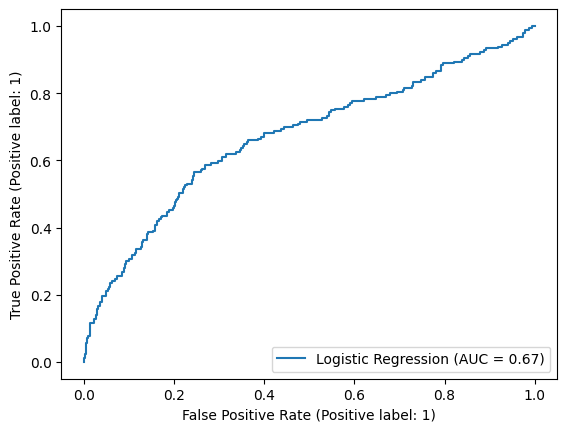

In [8]:
plot_roc_curve(log_reg, x_test, y_test, name = 'Logistic Regression')

In [9]:
y_proba = log_reg.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.6697173841603681

In [10]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=1000, 
                 learning_rate=0.03, depth=6, verbose=0)

catboost.fit(x_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


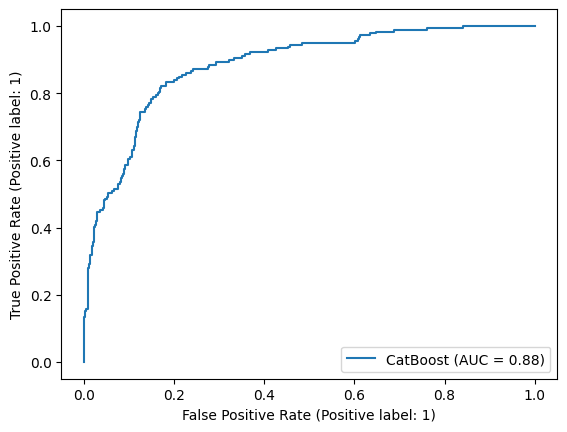

In [11]:
plot_roc_curve(catboost, x_test, y_test, name = 'CatBoost')

In [12]:
y_proba = catboost.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.8831991455800198

In [13]:
sub_proba = catboost.predict_proba(df_test)
pred_col=np.c_[id,sub_proba[:,1]]

submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
submission["Id"] = submission["Id"].astype("Int32")
submission

,Id,Y
0,2604,0.012013
1,2605,0.009254
2,2606,0.005676
3,2607,0.001723
4,2608,0.582026
...,...,...
3599,6203,0.109019
3600,6204,0.008120
3601,6205,0.005953
3602,6206,0.015809


In [14]:
submission.to_csv('submission.csv', index=False)

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150)
rf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=150)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


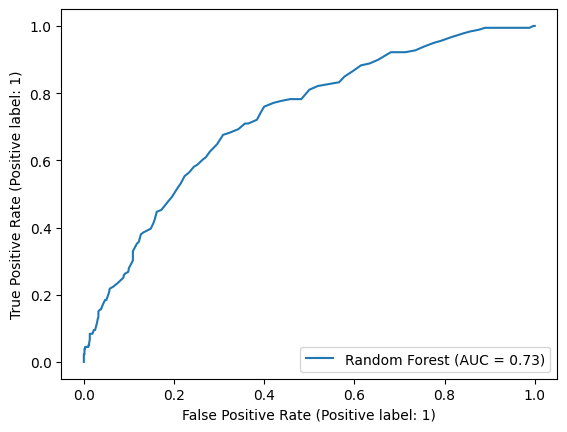

In [16]:
plot_roc_curve(rf, x_test, y_test, name = 'Random Forest')

In [17]:
# y_proba = rf.predict_proba(x_test)
# roc_auc_score(y_test, y_proba[:,1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


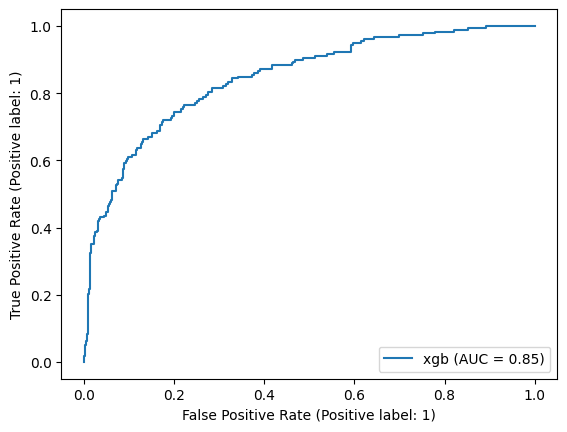

In [18]:
import xgboost as xgb

xgb1 = xgb.XGBClassifier(n_estimators=100)

xgb1.fit(x_train, y_train)

plot_roc_curve(xgb1, x_test, y_test, name = 'xgb')

In [25]:
from sklearn.ensemble import StackingClassifier
# define the base models
level0 = list()
level0.append(('xg', xgb.XGBClassifier(n_estimators=100)))
level0.append(('cat', CatBoostClassifier(iterations=1000, 
                 learning_rate=0.03, depth=6, verbose=0)))
# define meta learner model
level1 = CatBoostClassifier(iterations=1000, 
                 learning_rate=0.03, depth=6, verbose=0)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)


In [26]:
model.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_b...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x126d01480>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x126d39f60>)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


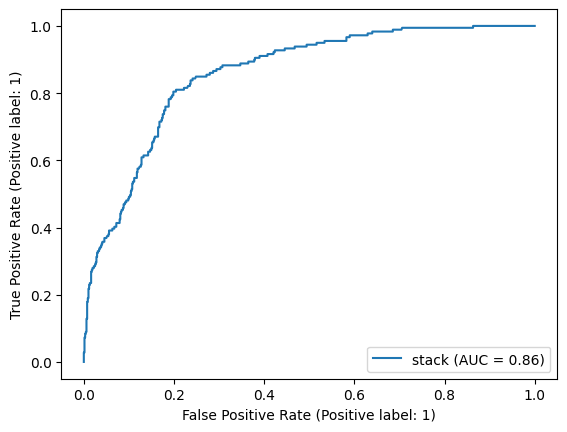

In [27]:
plot_roc_curve(model, x_test, y_test, name = 'stack')

In [22]:
y_proba = model.predict_proba(x_test)
roc_auc_score(y_test, y_proba[:,1])

0.8793460400920144

In [23]:
sub_proba = catboost.predict_proba(df_test)
pred_col=np.c_[id,sub_proba[:,1]]

submission = pd.DataFrame(pred_col, columns = ['Id','Y'])
submission["Id"] = submission["Id"].astype("Int32")
submission


,Id,Y
0,2604,0.012013
1,2605,0.009254
2,2606,0.005676
3,2607,0.001723
4,2608,0.582026
...,...,...
3599,6203,0.109019
3600,6204,0.008120
3601,6205,0.005953
3602,6206,0.015809


In [24]:
submission.to_csv('3submission.csv', index=False)